# 학습 내용
 - 3.3 GAN으로 MNIST 데이터의 패턴을 학습하여 세상에 없는 글씨체를 만든다

# 3.3 GAN with MNIST
 - MNIST 데이터셋의 패턴을 학습하여 스스로 글씨를 생성할 수 있을까?
 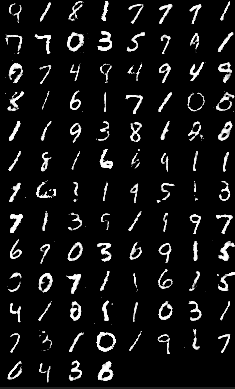

### Data Loader 생성

In [1]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize, Normalize, RandomHorizontalFlip, RandomCrop
import torchvision.datasets as datasets

batch_size = 100

# MNIST Dataset
transform = transforms.Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]) # -1 ~ 1 사이로 정규화

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Generator와 Discriminator 모델 아키텍처 설계

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# 가짜 생성기
class Generator(nn.Module):
    
    # 코딩타임
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    ##########

# 가짜 판별기
class Discriminator(nn.Module):

    # 코딩타임
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    ##########

### 두 모델 G, D 선언

In [29]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2) # 28 * 28 = 784

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

### Optimizer, Loss Function 선언

In [30]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

### Generator 학습 알고리즘 제작

In [34]:
# from torch.autograd import Variable

def G_train(x):
    #=======================Train the generator=======================#
    
    # 코딩타임
    
    G.zero_grad()
    
    z = torch.randn(batch_size, z_dim).to(device)
    y = torch.ones(batch_size, 1).to(device)
    
    G_output = G(z)
    D_output = D(G_output) 
    G_loss = criterion(D_output, y)
    
    G_loss.backward()
    G_optimizer.step()
    ##########
        
    return G_loss.data.item()

### Discriminator 학습 알고리즘 제작

In [35]:
def D_train(x):
    #=======================Train the discriminator=======================#
    
    # 코딩타임
    
    D.zero_grad()
    
    x_real = x.view(-1, mnist_dim)
    y_real = torch.ones(batch_size, 1)
    
    x_real, y_real = x_real.to(device), y_real.to(device)
    
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)
    
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    ##########
        
    return  D_loss.data.item()

### 1 epoch씩 학습시키며, 결과 출력하기!

[1/20]: loss_discre.: 2.04465, loss_gen.: 1.09702


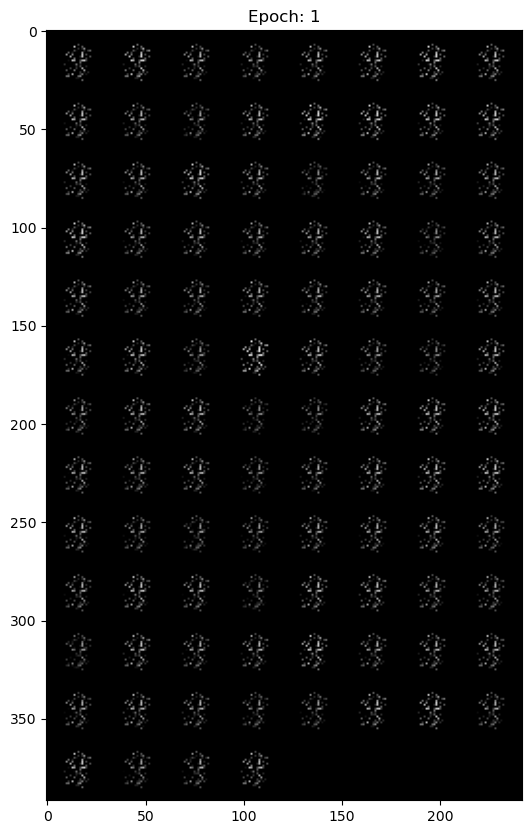

[2/20]: loss_discre.: 1.09091, loss_gen.: 1.26176


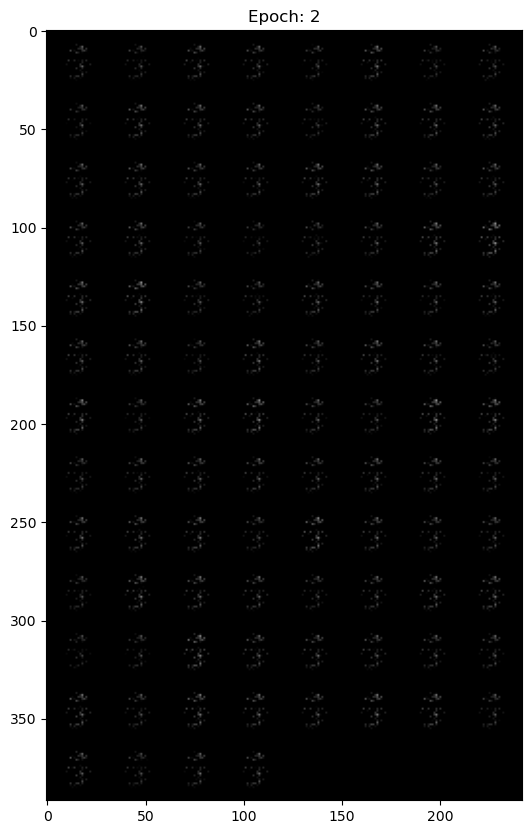

[3/20]: loss_discre.: 2.03723, loss_gen.: 0.87901


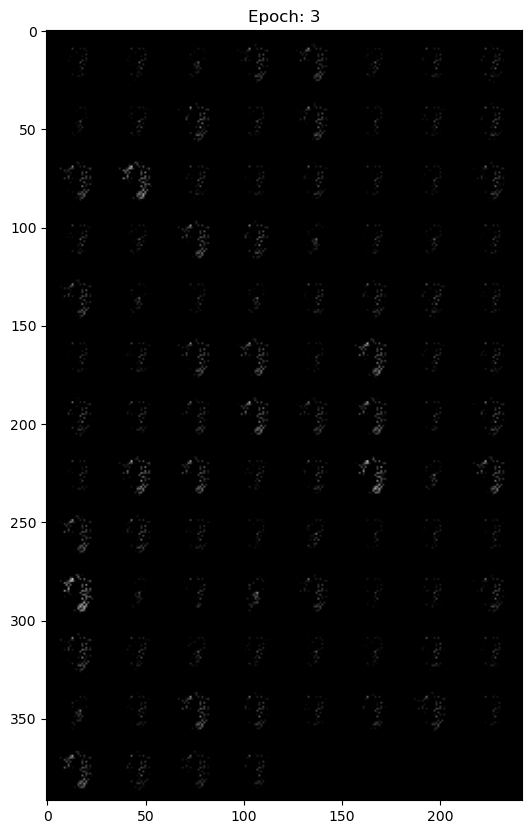

[4/20]: loss_discre.: 2.45971, loss_gen.: 0.79726


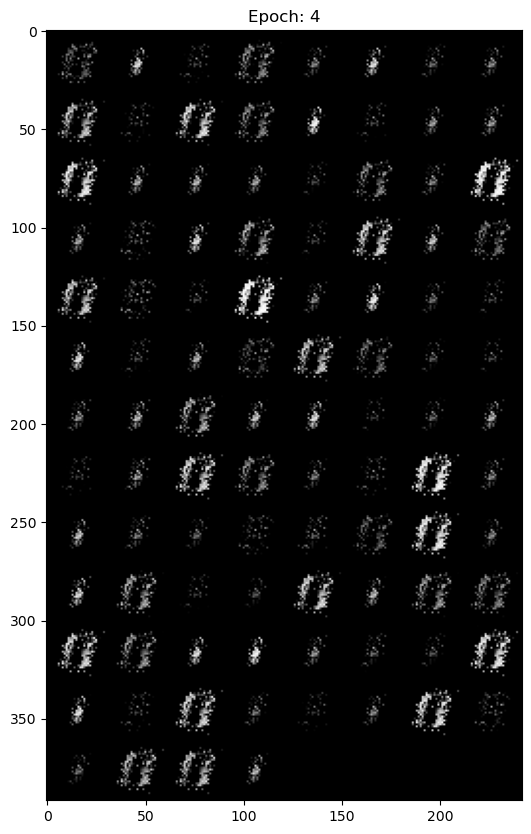

[5/20]: loss_discre.: 2.59202, loss_gen.: 0.60937


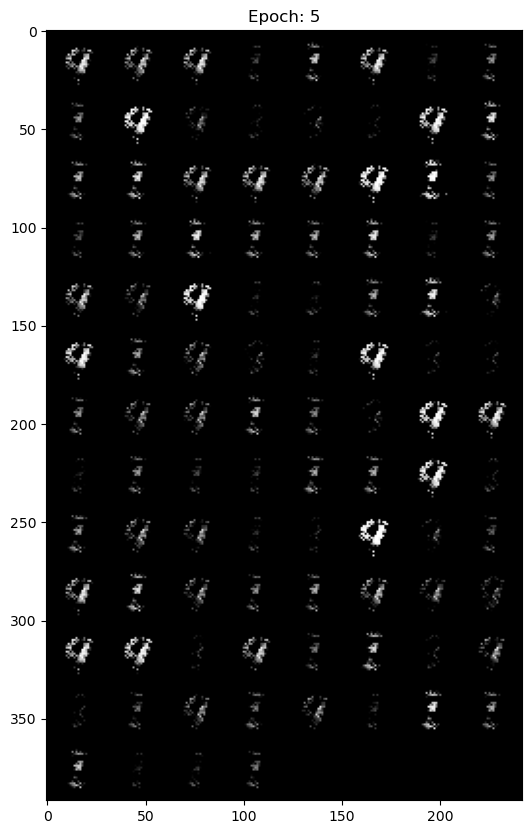

[6/20]: loss_discre.: 2.70067, loss_gen.: 0.56575


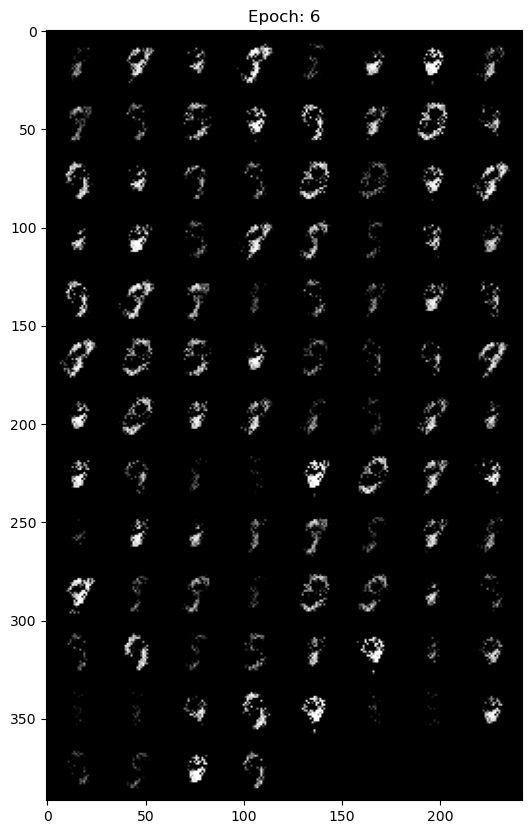

[7/20]: loss_discre.: 2.43162, loss_gen.: 0.6062


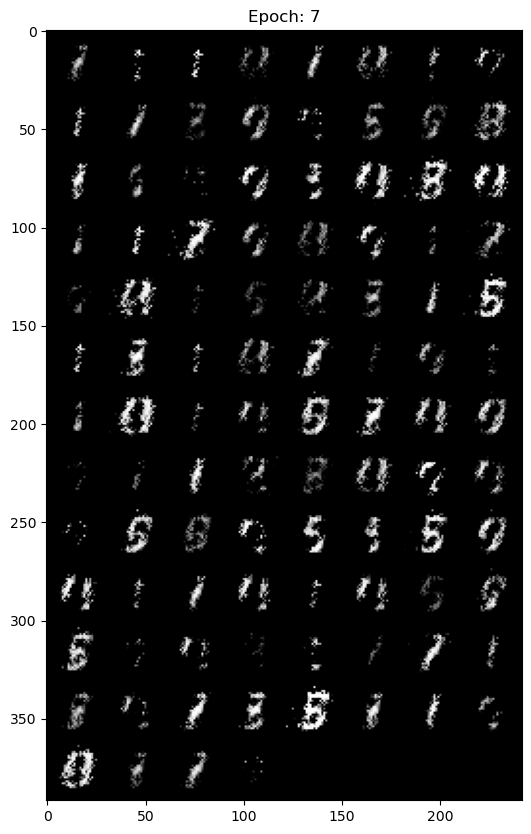

[8/20]: loss_discre.: 2.42475, loss_gen.: 0.60784


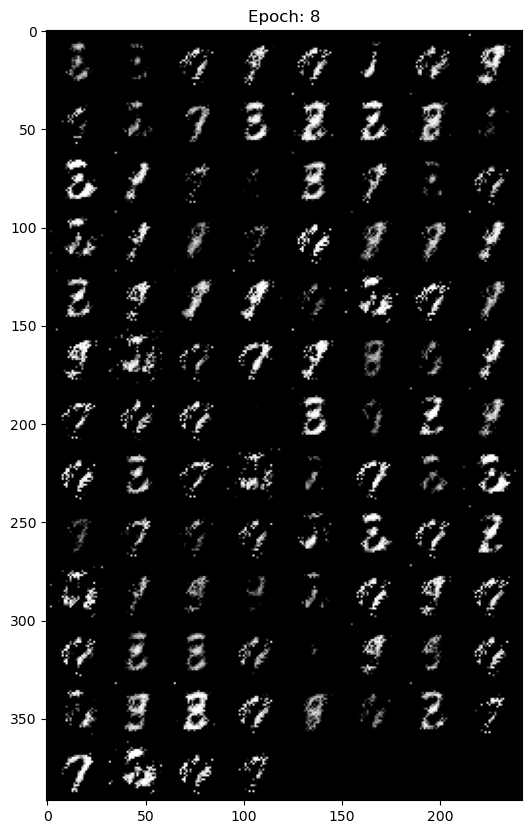

[9/20]: loss_discre.: 2.4448, loss_gen.: 0.61635


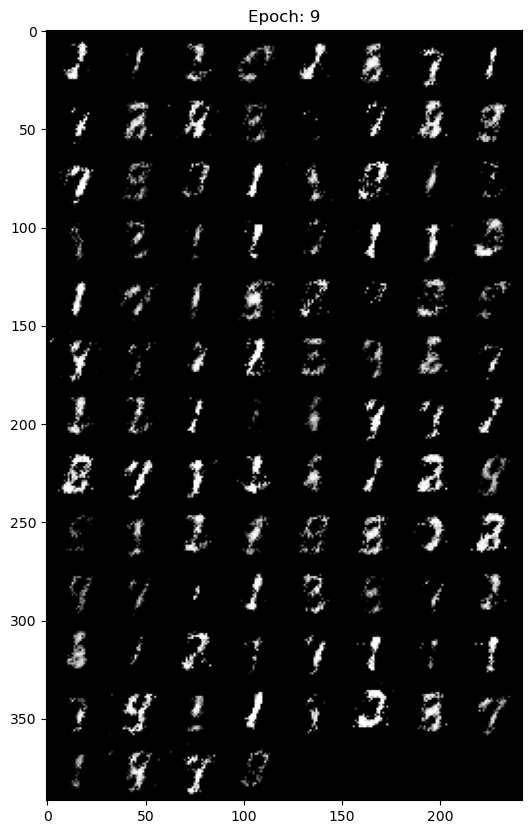

[10/20]: loss_discre.: 2.34288, loss_gen.: 0.63449


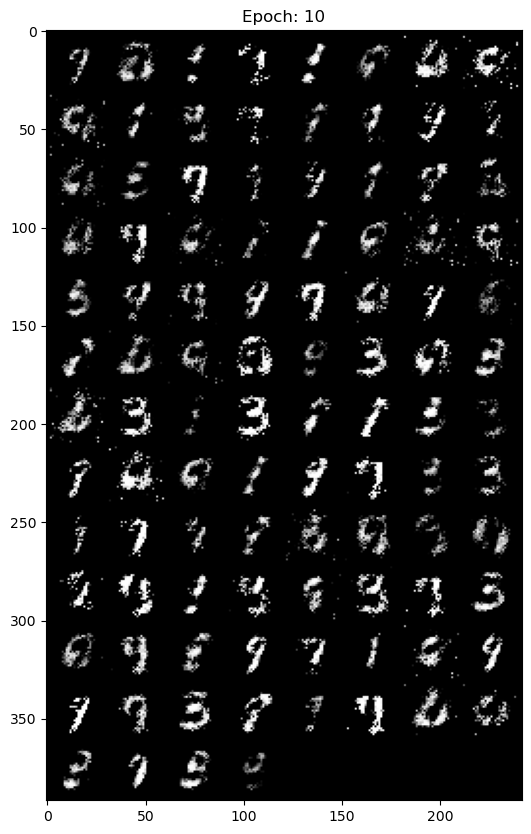

[11/20]: loss_discre.: 2.26322, loss_gen.: 0.68296


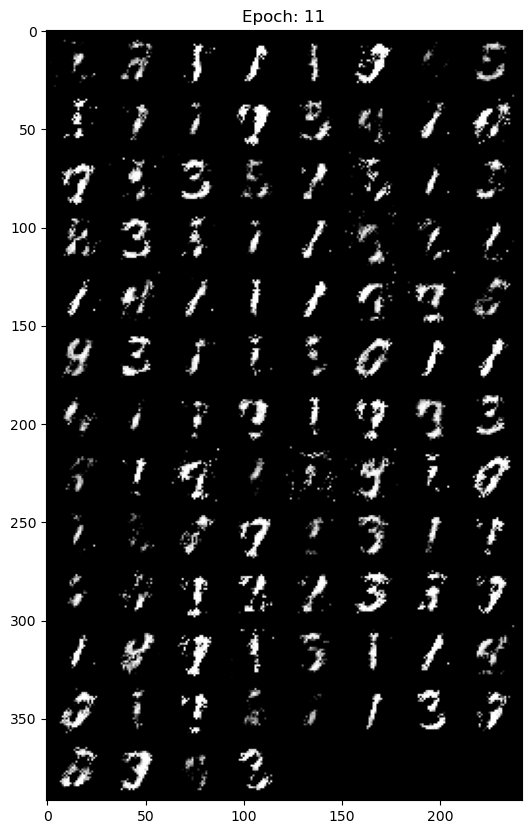

[12/20]: loss_discre.: 2.42394, loss_gen.: 0.64472


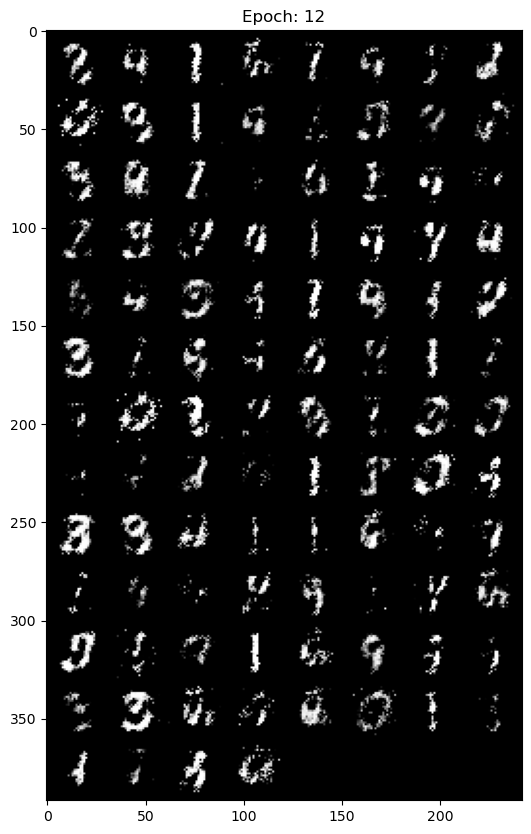

[13/20]: loss_discre.: 2.37831, loss_gen.: 0.64193


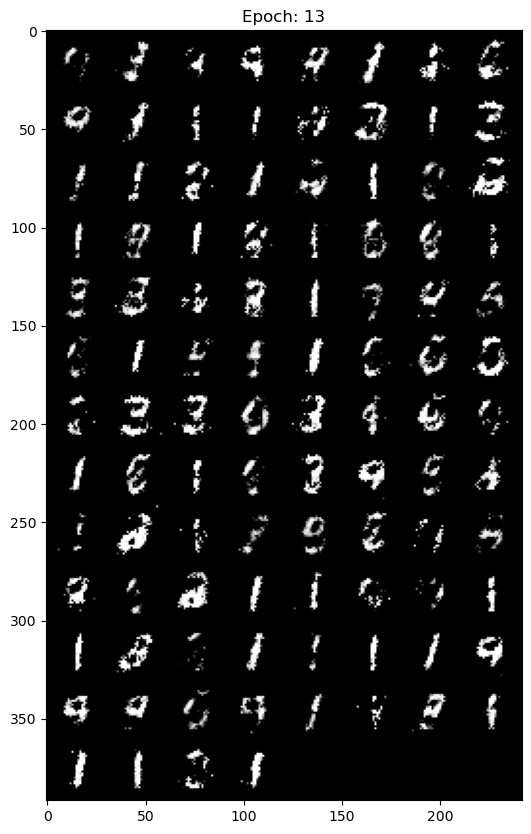

[14/20]: loss_discre.: 2.22891, loss_gen.: 0.69244


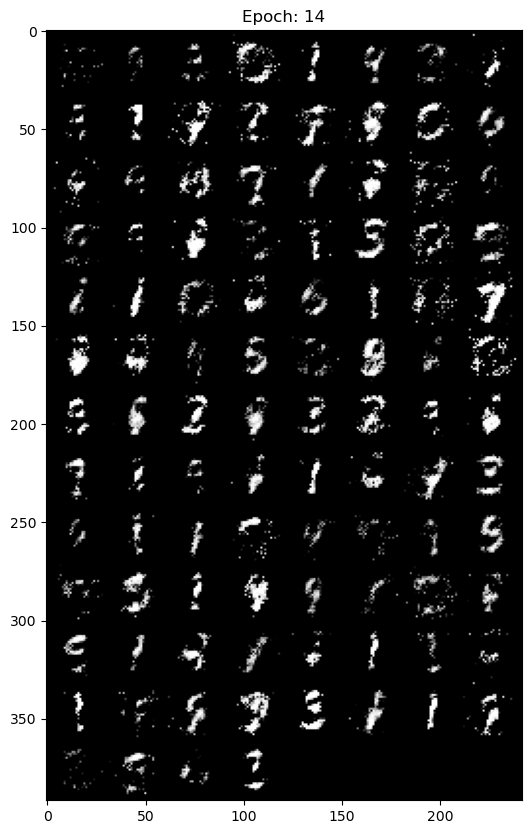

[15/20]: loss_discre.: 1.97367, loss_gen.: 0.78017


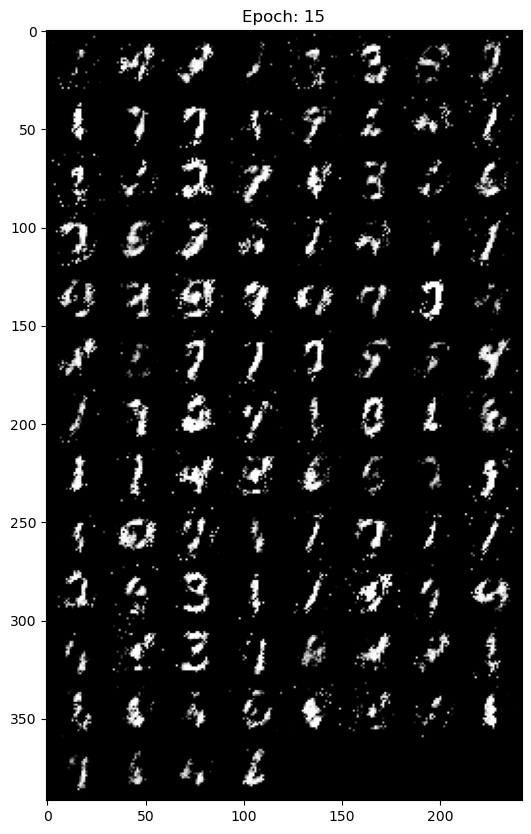

[16/20]: loss_discre.: 1.98551, loss_gen.: 0.76821


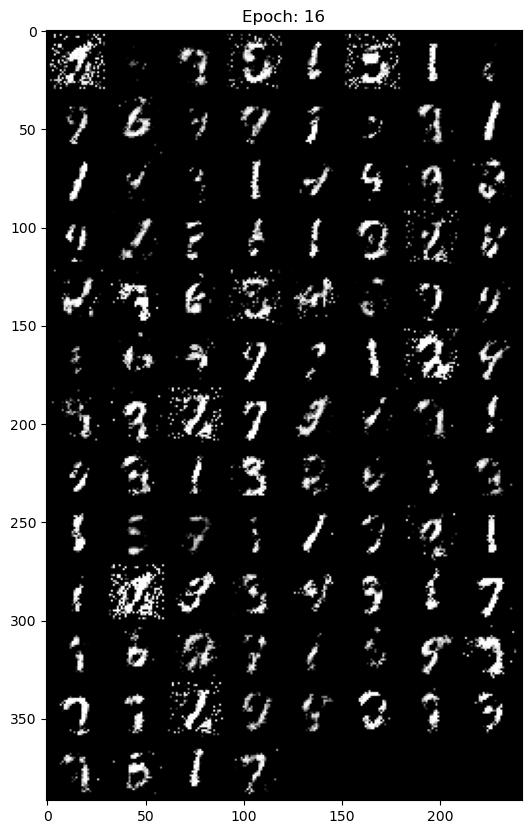

[17/20]: loss_discre.: 1.9122, loss_gen.: 0.78444


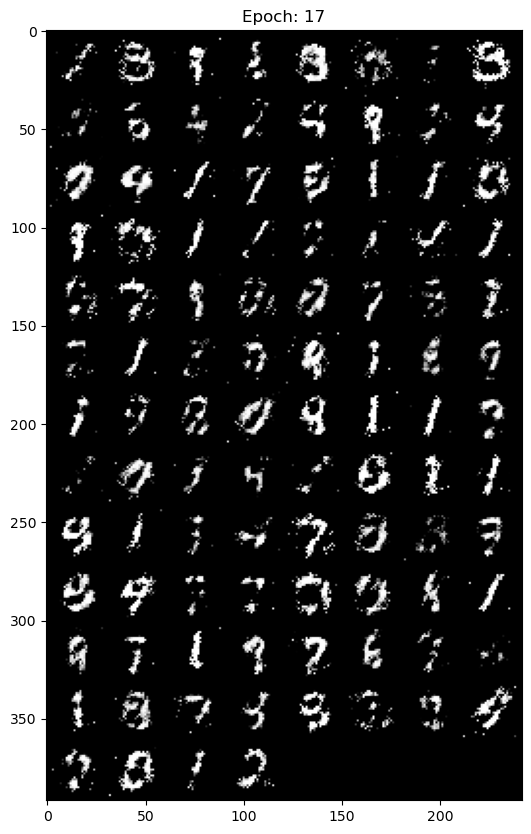

[18/20]: loss_discre.: 1.79681, loss_gen.: 0.83903


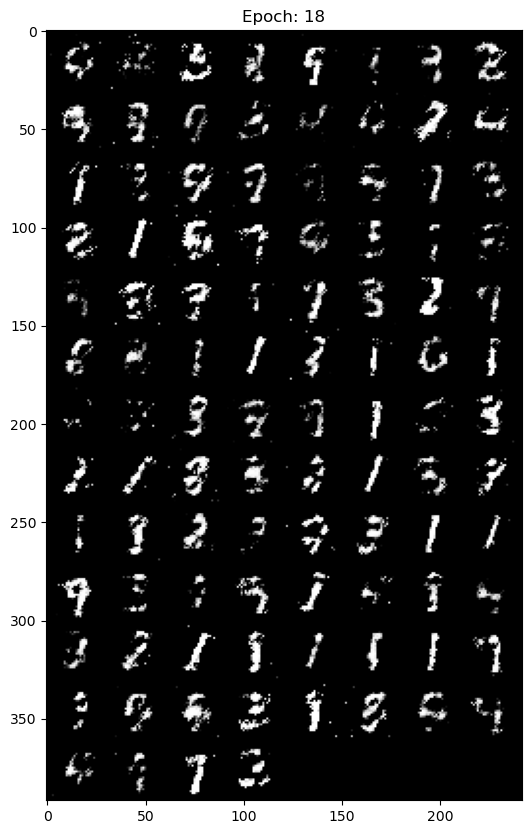

[19/20]: loss_discre.: 1.84078, loss_gen.: 0.82341


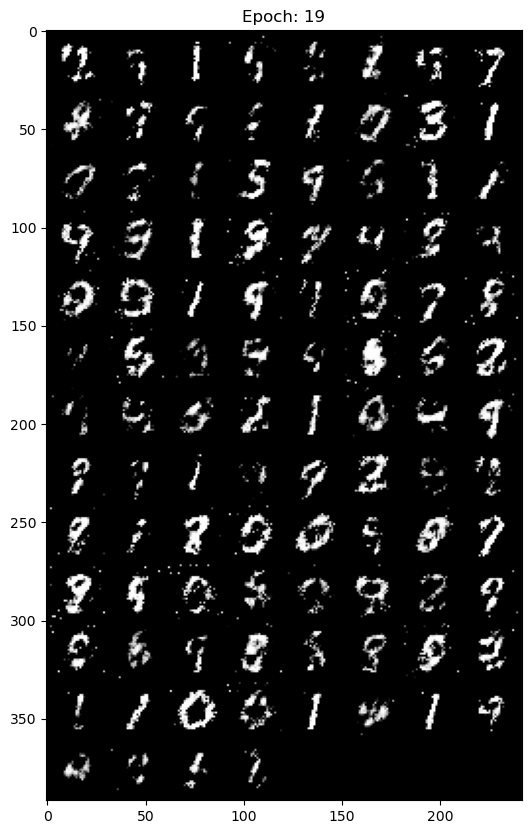

[20/20]: loss_discre.: 1.78169, loss_gen.: 0.84132


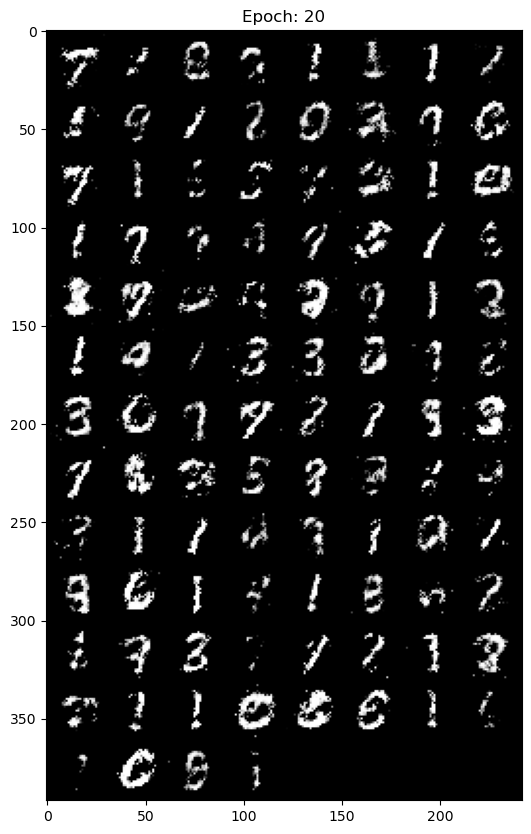

어쩌면...GAN을 과제에 사용할 수 있을지도...? >_<


In [36]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2

n_epoch = 20
cnt = 0
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print_dis_loss = round(float(torch.mean(torch.FloatTensor(G_losses))), 5)
    print_gen_loss = round(float(torch.mean(torch.FloatTensor(D_losses))), 5)
    print('[{}/{}]: loss_discre.: {}, loss_gen.: {}'.format(epoch, n_epoch, print_dis_loss, print_gen_loss))

    with torch.no_grad():
        test_z = torch.randn(batch_size, z_dim).to(device)
        generated = G(test_z)
        img_path = './GAN_MNIST.png'
        save_image(generated.view(generated.size(0), 1, 28, 28), img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.title('Epoch: {}'.format(epoch))
        plt.show()
    cnt += 1
    
print('어쩌면...GAN을 과제에 사용할 수 있을지도...? >_<')

#### 고생 많으셨습니다. 좋은 결과 있기를 바랍니다.